In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.datasets import load_breast_cancer

In [2]:
# Load sample dataset (breast cancer dataset)
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

print(f"Dataset shape: {X.shape}")
print(f"Features: {feature_names}")
print(f"Target classes: {target_names}")

Dataset shape: (569, 30)
Features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Target classes: ['malignant' 'benign']


In [3]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
# Feature scaling (optional for RandomForest but good practice)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# 1. Basic Random Forest model (baseline)
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train_scaled, y_train)
y_pred_base = rf_base.predict(X_test_scaled)

print("\n--- Baseline Random Forest Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_base):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_base, target_names=target_names))


--- Baseline Random Forest Results ---
Accuracy: 0.9708

Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.94      0.96        63
      benign       0.96      0.99      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



In [6]:
# 2. GridSearchCV for hyperparameter tuning
print("\n--- Grid Search Hyperparameter Tuning ---")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Use smaller param_grid for demonstration purposes (to avoid long execution time)
small_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=small_param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


--- Grid Search Hyperparameter Tuning ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.9522


In [7]:
# 3. RandomizedSearchCV (more efficient for large parameter spaces)
print("\n--- Randomized Search Hyperparameter Tuning ---")
random_grid = {
    'n_estimators': np.arange(100, 500, 100),
    'max_depth': [None] + list(np.arange(10, 50, 10)),
    'min_samples_split': np.arange(2, 12, 2),
    'min_samples_leaf': np.arange(1, 5),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

randomized_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=random_grid,
    n_iter=20,  # Number of parameter settings sampled
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy',
    random_state=42
)

randomized_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {randomized_search.best_params_}")
print(f"Best cross-validation score: {randomized_search.best_score_:.4f}")


--- Randomized Search Hyperparameter Tuning ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
35 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-pac

Best parameters: {'n_estimators': 300, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Best cross-validation score: 0.9572


In [8]:
# 4. Evaluate the best model from GridSearchCV
best_grid_model = grid_search.best_estimator_
y_pred_grid = best_grid_model.predict(X_test_scaled)
y_prob_grid = best_grid_model.predict_proba(X_test_scaled)[:, 1]

print("\n--- Best Grid Search Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_grid):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_grid, target_names=target_names))


--- Best Grid Search Model Evaluation ---
Accuracy: 0.9708

Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.94      0.96        63
      benign       0.96      0.99      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



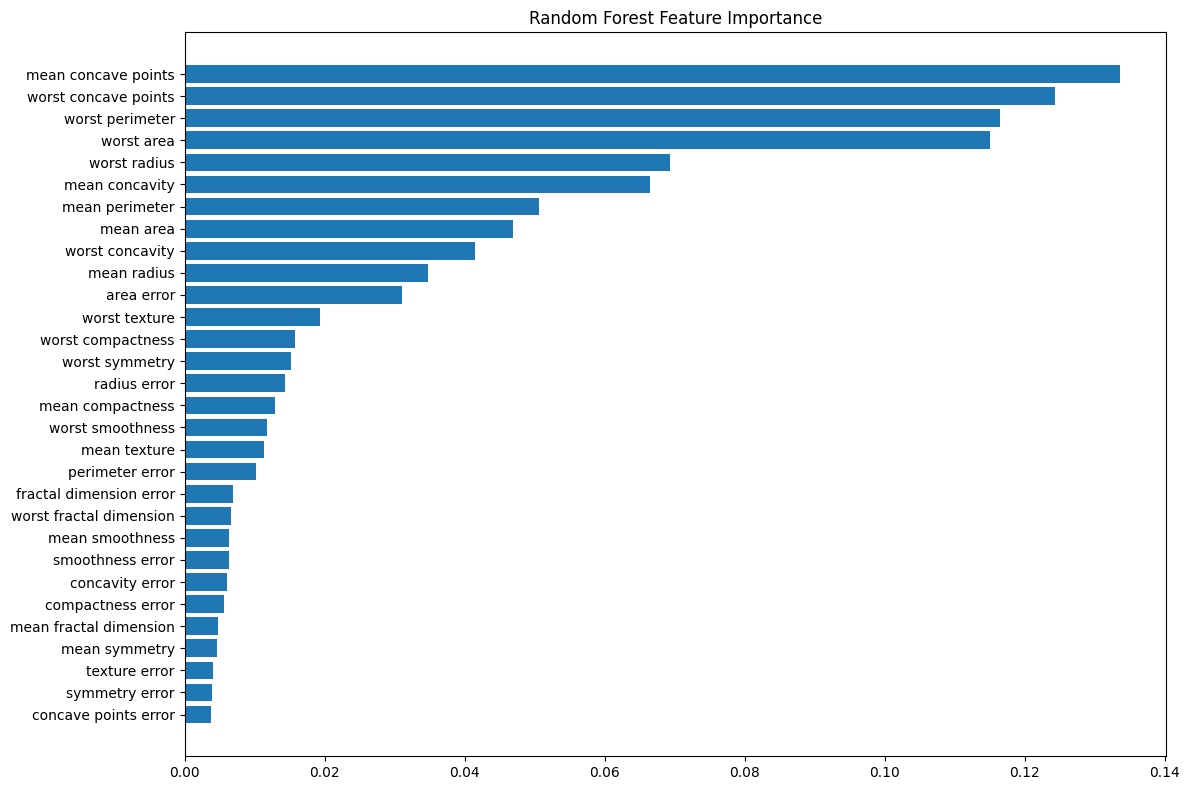

In [9]:
# 5. Feature importance analysis
feature_importances = best_grid_model.feature_importances_
sorted_idx = np.argsort(feature_importances)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.savefig('Random_forest_feature_importance.png')
plt.show()
plt.close()

In [10]:
# 6. Cross-validation of the best model
cv_scores = cross_val_score(best_grid_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard deviation: {np.std(cv_scores):.4f}")


Cross-validation scores: [0.95       0.95       0.975      0.94936709 0.93670886]
Mean CV accuracy: 0.9522
Standard deviation: 0.0125


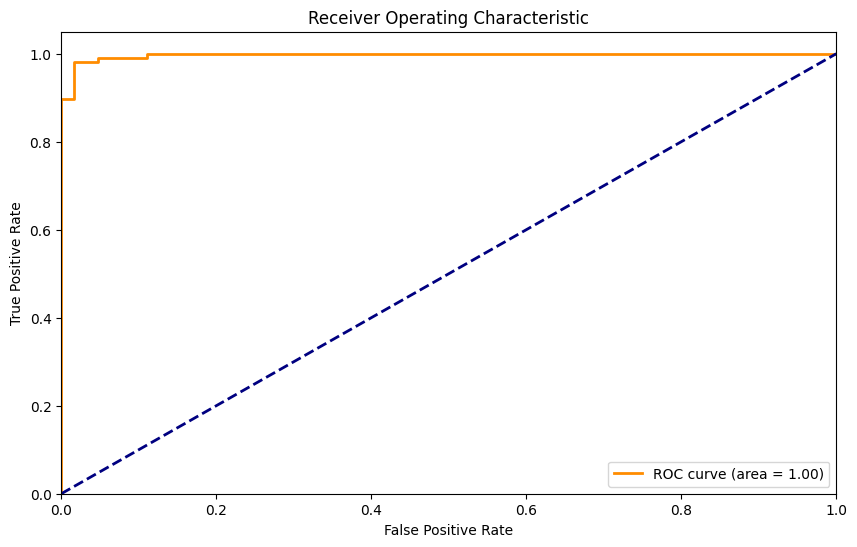

In [11]:
# 7. ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob_grid)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Random_forest_roc_curve.png')
plt.show()
plt.close()

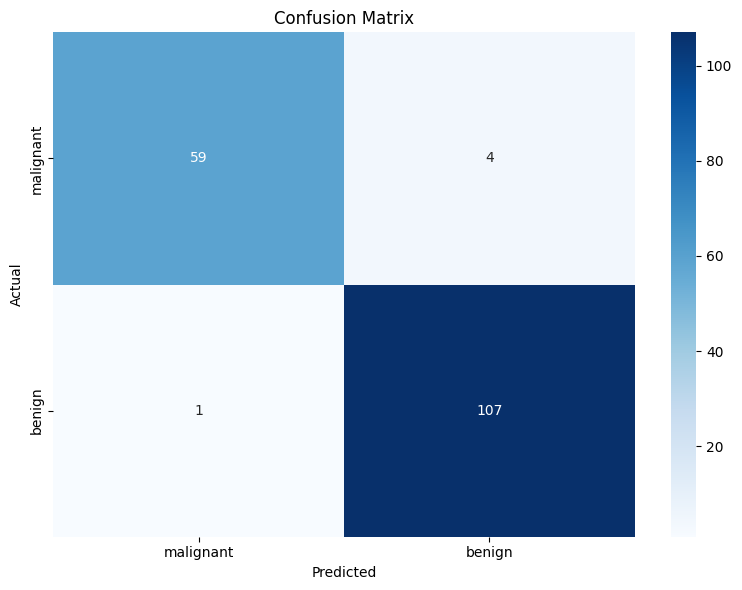

In [12]:
# 8. Confusion Matrix visualization
cm = confusion_matrix(y_test, y_pred_grid)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('Random_forest_confusion_matrix.png')
plt.show()
plt.close()

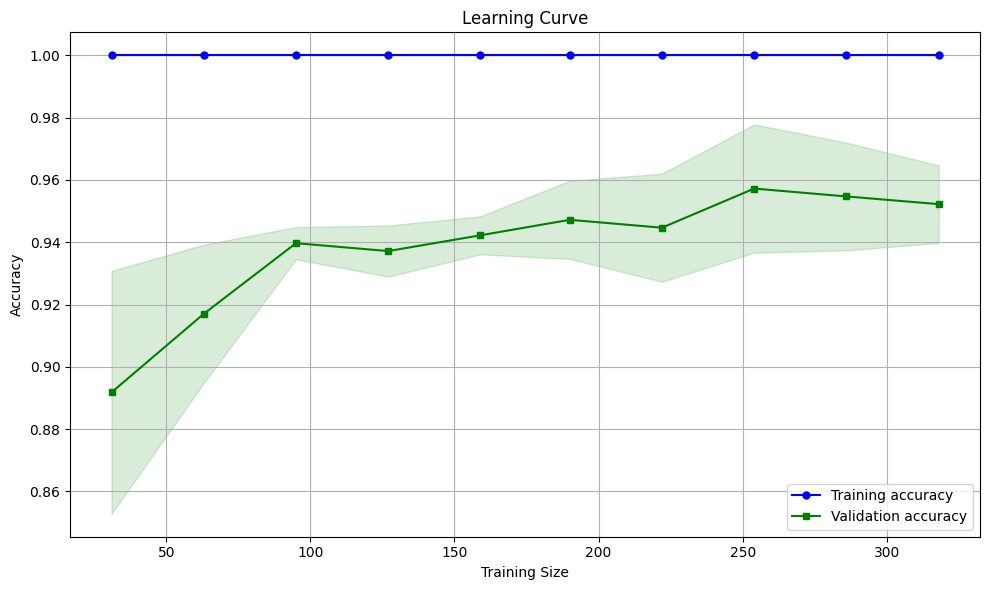

In [13]:
# 9. Learning curves (optional for deeper analysis)
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_grid_model, X_train_scaled, y_train, cv=5, 
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('Random_forest_learning_curve.png')
plt.show()
plt.close()

In [14]:
# 10. Fine-tuning specific parameters (optional based on previous findings)
# For example, fine-tuning n_estimators after discovering optimal ranges
print("\n--- Fine-tuning n_estimators ---")
estimator_range = np.arange(best_grid_model.n_estimators - 50, best_grid_model.n_estimators + 60, 10)
estimator_range = estimator_range[estimator_range > 0]  # Ensure positive values

param_grid_fine = {
    'n_estimators': estimator_range
}

# Create a new RF with the best parameters from before
rf_fine = RandomForestClassifier(
    random_state=42,
    max_depth=best_grid_model.max_depth,
    min_samples_split=best_grid_model.min_samples_split,
    # Add other parameters from best_grid_model as needed
)

grid_search_fine = GridSearchCV(
    estimator=rf_fine,
    param_grid=param_grid_fine,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

grid_search_fine.fit(X_train_scaled, y_train)
print(f"Fine-tuned n_estimators: {grid_search_fine.best_params_['n_estimators']}")
print(f"Fine-tuned accuracy: {grid_search_fine.best_score_:.4f}")


--- Fine-tuning n_estimators ---
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fine-tuned n_estimators: 220
Fine-tuned accuracy: 0.9572


In [16]:
# 11. Final model with all optimized parameters
final_params = grid_search.best_params_.copy()
final_params['n_estimators'] = grid_search_fine.best_params_['n_estimators']

final_model = RandomForestClassifier(random_state=42, **final_params)
final_model.fit(X_train_scaled, y_train)
y_pred_final = final_model.predict(X_test_scaled)

print("\n--- Final Optimized Model Results ---")
print(f"Final parameters: {final_params}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final, target_names=target_names))

# Save the final model (optional)
from joblib import dump
dump(final_model, 'Random_forest_optimized.joblib')
print("\nFinal model saved as 'optimized_random_forest.joblib'")


--- Final Optimized Model Results ---
Final parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 220}
Accuracy: 0.9708

Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.94      0.96        63
      benign       0.96      0.99      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171


Final model saved as 'optimized_random_forest.joblib'
